In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch

In [6]:
import os
os.getcwd()

'c:\\Users\\k_schr40\\Documents\\Research\\FeatureCompression\\FeatureCompression'

In [5]:
os.chdir('..')

In [9]:
from datasets import get_min_max_values, get_quantization_thresholds, load_data, get_minmax_thresholds

In [11]:
dataset = 'wine_quality'
scratch = '.'
X_tensor, y_tensor = load_data(dataset, scratch, False)

In [13]:
X_tensor.shape, y_tensor.shape

(torch.Size([6497, 11]), torch.Size([6497, 1]))

In [72]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
counter = 0
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor)):
    counter += 1
    X_train_tensor = X_tensor[train_idx]
    y_train_tensor = y_tensor[train_idx]
    X_val_tensor = X_tensor[val_idx]
    y_val_tensor = y_tensor[val_idx]

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_array = scaler_X.fit_transform(X_train_tensor)
    y_train_array = scaler_y.fit_transform(y_train_tensor)
    X_val_array = scaler_X.transform(X_val_tensor)
    y_val_array = scaler_y.transform(y_val_tensor)

    X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_array, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32)
    n_estimators = 100

    xgb_model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_model.fit(
        X_train_tensor.numpy(),
        y_train_tensor.numpy(),
        eval_set=[(X_val_tensor.numpy(), y_val_tensor.numpy())],
        verbose=False
    )

    val_pred = xgb_model.predict(X_val_tensor.numpy())
    val_error = np.mean((val_pred - y_val_tensor.numpy().flatten()) ** 2)
    print(f"Fold {fold + 1}/{k_folds}, Validation Error: {val_error:.4f}")



Fold 1/5, Validation Error: 0.5709
Fold 2/5, Validation Error: 0.5882
Fold 3/5, Validation Error: 0.5915
Fold 4/5, Validation Error: 0.5981
Fold 5/5, Validation Error: 0.5510


In [73]:
from tqdm import tqdm

num_features = X_tensor.shape[1]

count_df = pd.DataFrame(columns = [f'f{i}' for i in range(num_features)], data = np.zeros((n_estimators, num_features)))
# Get the first tree dump
booster = xgb_model.get_booster()
tree_info = booster.get_dump(with_stats=True)

for f in tqdm(range(n_estimators)):
    current_tree = tree_info[f]
    # Example: 0:[f10<0.136851683] yes=1,no=2,missing=2,gain=693.58136,cover=4135
    for line in current_tree.split('\n'):
        if ':' in line and 'leaf' not in line:
            split = line.split(':')[1]
            feature = split.split('<')[0].strip()
            feature = feature[1:]  # Remove the leading '['
            count_df.at[f, feature] += 1



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1315.67it/s]


In [74]:
count_df.sum().sum()

np.float64(1365.0)

In [75]:
100 * (2**6 -1)

6300

In [76]:
np.log2(count_df.sum(axis=0))

f0     7.055282
f1     7.199672
f2     6.599913
f3     7.169925
f4     6.845490
f5     7.076816
f6     7.118941
f7     6.523562
f8     6.857981
f9     6.906891
f10    6.988685
dtype: float64

In [41]:
n_estimators * (2**6 - 1)

63000

In [24]:
# Print the depth of all trees in the trained XGBoost model
booster = xgb_model.get_booster()
tree_info = booster.get_dump(with_stats=True)
depths = []

for tree in tree_info:
    max_depth = 0
    for line in tree.split('\n'):
        if line.strip() == '':
            continue
        # Count the number of '\t' to determine the depth of the node
        depth = line.count('\t')
        if depth > max_depth:
            max_depth = depth
    depths.append(max_depth)

print("Depth of each tree:", depths)
print("Max depth:", max(depths))
print("Min depth:", min(depths))

Depth of each tree: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

c:\Users\k_schr40\Documents\Research\FeatureCompression\FeatureCompression\compression_venv\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

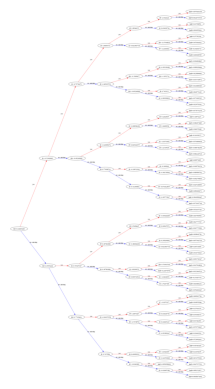

In [23]:
from xgboost import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.show()